Import Libraries

In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
glob("*.csv")

['takehome_users.csv', 'takehome_user_engagement.csv']

In [3]:
df = pd.read_csv('takehome_users.csv', encoding='latin-1')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
df2 = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [8]:
df = pd.concat([df, pd.get_dummies(df.creation_source, drop_first=False)], axis=1)

In [9]:
df = df.drop(['creation_source', 'name', 'email'], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   last_session_creation_time  8823 non-null   float64       
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          6417 non-null   float64       
 7   GUEST_INVITE                12000 non-null  uint8         
 8   ORG_INVITE                  12000 non-null  uint8         
 9   PERSONAL_PROJECTS           12000 non-null  uint8         
 10  SIGNUP                      12000 non-null  uint8         
 11  SIGNUP_GOOGLE_AUTH          12000 non-null  uint8     

In [11]:
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [13]:
df = df.drop(['last_session_creation_time'], axis=1)

In [14]:
df["org_id"].value_counts().head(106)

0      319
1      233
2      201
3      168
4      159
      ... 
92      30
201     30
126     30
275     29
87      29
Name: org_id, Length: 106, dtype: int64

In [15]:
df["org_id"].value_counts().head(106).sum()

6000

In [16]:
def org_id_sorter(keys, org_id):
    if org_id in keys:
        answer = 1
    else:
        answer = 0
    return answer

from functools import partial
org_id_sort = partial(org_id_sorter, df.org_id.value_counts().head(106).keys())

df['large_org'] = df['org_id'].apply(org_id_sort).astype('int')
df = df.drop(['org_id'], axis=1)

df.head()

,object_id,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,large_org
0,1,2014-04-22 03:53:30,1,0,10803.0,1,0,0,0,0,1
1,2,2013-11-15 03:45:04,0,0,316.0,0,1,0,0,0,1
2,3,2013-03-19 23:14:52,0,0,1525.0,0,1,0,0,0,1
3,4,2013-05-21 08:09:28,0,0,5151.0,1,0,0,0,0,1
4,5,2013-01-17 10:14:20,0,0,5240.0,1,0,0,0,0,0


In [17]:
df["large_org"].value_counts()

1    6000
0    6000
Name: large_org, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   invited_by_user_id          6417 non-null   float64       
 5   GUEST_INVITE                12000 non-null  uint8         
 6   ORG_INVITE                  12000 non-null  uint8         
 7   PERSONAL_PROJECTS           12000 non-null  uint8         
 8   SIGNUP                      12000 non-null  uint8         
 9   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8         
 10  large_org                   12000 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), 

In [19]:
df["invited_by_user_id"].isnull().value_counts().head()

False    6417
True     5583
Name: invited_by_user_id, dtype: int64

In [20]:
df['user_invited'] = df["invited_by_user_id"].isnull()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   invited_by_user_id          6417 non-null   float64       
 5   GUEST_INVITE                12000 non-null  uint8         
 6   ORG_INVITE                  12000 non-null  uint8         
 7   PERSONAL_PROJECTS           12000 non-null  uint8         
 8   SIGNUP                      12000 non-null  uint8         
 9   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8         
 10  large_org                   12000 non-null  int32         
 11  user_invited                12000 non-null  bool      

In [22]:
df["user_invited"].value_counts()

False    6417
True     5583
Name: user_invited, dtype: int64

In [23]:
df['creation_year'] = df['creation_time'].dt.year
df['creation_month'] = df['creation_time'].dt.month
df['creation_day'] = df['creation_time'].dt.dayofweek
df['creation_hour'] = df['creation_time'].dt.hour
df = df.drop(['creation_time'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   invited_by_user_id          6417 non-null   float64
 4   GUEST_INVITE                12000 non-null  uint8  
 5   ORG_INVITE                  12000 non-null  uint8  
 6   PERSONAL_PROJECTS           12000 non-null  uint8  
 7   SIGNUP                      12000 non-null  uint8  
 8   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 9   large_org                   12000 non-null  int32  
 10  user_invited                12000 non-null  bool   
 11  creation_year               12000 non-null  int64  
 12  creation_month              12000 non-null  int64  
 13  creation_day                120

In [24]:
df = df.drop(['invited_by_user_id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   object_id                   12000 non-null  int64
 1   opted_in_to_mailing_list    12000 non-null  int64
 2   enabled_for_marketing_drip  12000 non-null  int64
 3   GUEST_INVITE                12000 non-null  uint8
 4   ORG_INVITE                  12000 non-null  uint8
 5   PERSONAL_PROJECTS           12000 non-null  uint8
 6   SIGNUP                      12000 non-null  uint8
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8
 8   large_org                   12000 non-null  int32
 9   user_invited                12000 non-null  bool 
 10  creation_year               12000 non-null  int64
 11  creation_month              12000 non-null  int64
 12  creation_day                12000 non-null  int64
 13  creation_hour               12000 non-null  int64
dtypes: boo

In [25]:
df["object_id"].value_counts().max()

1

In [26]:
df.index = df["object_id"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   object_id                   12000 non-null  int64
 1   opted_in_to_mailing_list    12000 non-null  int64
 2   enabled_for_marketing_drip  12000 non-null  int64
 3   GUEST_INVITE                12000 non-null  uint8
 4   ORG_INVITE                  12000 non-null  uint8
 5   PERSONAL_PROJECTS           12000 non-null  uint8
 6   SIGNUP                      12000 non-null  uint8
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8
 8   large_org                   12000 non-null  int32
 9   user_invited                12000 non-null  bool 
 10  creation_year               12000 non-null  int64
 11  creation_month              12000 non-null  int64
 12  creation_day                12000 non-null  int64
 13  creation_hour               12000 non-null  int64
dtypes: boo

In [27]:
df2["visited"].value_counts()

1    207917
Name: visited, dtype: int64

In [28]:
df2 = df2.drop(['visited'], axis=1)

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 MB


In [30]:
df2.head()

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


In [31]:
df2.index = df2.time_stamp
df2 = df2.sort_index()
df2.head()

,time_stamp,user_id
time_stamp,,
2012-05-31 08:20:06,2012-05-31 08:20:06,10012
2012-05-31 15:47:36,2012-05-31 15:47:36,3428
2012-05-31 17:19:37,2012-05-31 17:19:37,9899
2012-05-31 21:58:33,2012-05-31 21:58:33,1693
2012-06-01 00:17:30,2012-06-01 00:17:30,6102


In [32]:
df2["user_id"].unique().shape

(8823,)

In [33]:
login_counts = df2["user_id"].value_counts()
login_counts.index.name = "user_id"
login_counts.name = 'login_count'
login_counts

user_id
3623    606
906     600
1811    593
7590    590
8068    585
       ... 
3075      1
7830      1
7687      1
8287      1
4051      1
Name: login_count, Length: 8823, dtype: int64

In [34]:
df.index.name = 'user_id'

In [35]:
df = df.merge(login_counts, how='left', left_index=True, right_index=True)
df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,large_org,user_invited,creation_year,creation_month,creation_day,creation_hour,login_count
user_id,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,1,False,2014,4,1,3,1.0
2,2,0,0,0,1,0,0,0,1,False,2013,11,4,3,14.0
3,3,0,0,0,1,0,0,0,1,False,2013,3,1,23,1.0
4,4,0,0,1,0,0,0,0,1,False,2013,5,1,8,1.0
5,5,0,0,1,0,0,0,0,0,False,2013,1,3,10,1.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   GUEST_INVITE                12000 non-null  uint8  
 4   ORG_INVITE                  12000 non-null  uint8  
 5   PERSONAL_PROJECTS           12000 non-null  uint8  
 6   SIGNUP                      12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 8   large_org                   12000 non-null  int32  
 9   user_invited                12000 non-null  bool   
 10  creation_year               12000 non-null  int64  
 11  creation_month              12000 non-null  int64  
 12  creation_day                12000 non-null  int64  
 13  creation_hour               120

In [37]:
def impute_zero(x):
    if x is None:
        return 0
    else:
        return x

df['login_count2'] = df['login_count'].apply(impute_zero)
df = df.drop(['login_count'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   GUEST_INVITE                12000 non-null  uint8  
 4   ORG_INVITE                  12000 non-null  uint8  
 5   PERSONAL_PROJECTS           12000 non-null  uint8  
 6   SIGNUP                      12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 8   large_org                   12000 non-null  int32  
 9   user_invited                12000 non-null  bool   
 10  creation_year               12000 non-null  int64  
 11  creation_month              12000 non-null  int64  
 12  creation_day                12000 non-null  int64  
 13  creation_hour               120

In [38]:
df["login_count2"].value_counts()

1.0      6235
2.0       340
3.0       241
4.0       181
5.0       110
         ... 
332.0       1
86.0        1
395.0       1
509.0       1
255.0       1
Name: login_count2, Length: 402, dtype: int64

In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2012-05-31 08:20:06 to 2014-06-06 14:58:50
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.8 MB


In [40]:
logins_df = df2.user_id
logins_df.head()

time_stamp
2012-05-31 08:20:06    10012
2012-05-31 15:47:36     3428
2012-05-31 17:19:37     9899
2012-05-31 21:58:33     1693
2012-06-01 00:17:30     6102
Name: user_id, dtype: int64

In [41]:
logins_df.index[0]

Timestamp('2012-05-31 08:20:06')

In [42]:
logins_df.index[-1]

Timestamp('2014-06-06 14:58:50')

In [43]:
login_dates = pd.date_range(start=logins_df.index[0], end=logins_df.index[-1], freq='D', normalize=True)
login_dates

DatetimeIndex(['2012-05-31', '2012-06-01', '2012-06-02', '2012-06-03',
               '2012-06-04', '2012-06-05', '2012-06-06', '2012-06-07',
               '2012-06-08', '2012-06-09',
               ...
               '2014-05-28', '2014-05-29', '2014-05-30', '2014-05-31',
               '2014-06-01', '2014-06-02', '2014-06-03', '2014-06-04',
               '2014-06-05', '2014-06-06'],
              dtype='datetime64[ns]', length=737, freq='D')

In [44]:
for date in login_dates[:5]:
    print(date)

2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-02 00:00:00
2012-06-03 00:00:00
2012-06-04 00:00:00


In [45]:
logins_df

time_stamp
2012-05-31 08:20:06    10012
2012-05-31 15:47:36     3428
2012-05-31 17:19:37     9899
2012-05-31 21:58:33     1693
2012-06-01 00:17:30     6102
                       ...  
2014-06-04 23:32:13     4625
2014-06-04 23:34:04     9325
2014-06-04 23:46:31     9558
2014-06-04 23:56:26      341
2014-06-06 14:58:50     4051
Name: user_id, Length: 207917, dtype: int64

In [46]:
def max_weekly_logins(user_id):
    temp = logins_df.loc[logins_df == user_id]
    temp2 = temp.resample('1D').count().astype('bool')
    temp3 = temp2.rolling(7).sum()
    return temp3.max()


df['max_weekly_logins'] = df['object_id'].apply(max_weekly_logins)

df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,large_org,user_invited,creation_year,creation_month,creation_day,creation_hour,login_count2,max_weekly_logins
user_id,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,1,False,2014,4,1,3,1.0,NaN
2,2,0,0,0,1,0,0,0,1,False,2013,11,4,3,14.0,3.0
3,3,0,0,0,1,0,0,0,1,False,2013,3,1,23,1.0,NaN
4,4,0,0,1,0,0,0,0,1,False,2013,5,1,8,1.0,NaN
5,5,0,0,1,0,0,0,0,0,False,2013,1,3,10,1.0,NaN


In [47]:
df["login_count2"].value_counts()

1.0      6235
2.0       340
3.0       241
4.0       181
5.0       110
         ... 
332.0       1
86.0        1
395.0       1
509.0       1
255.0       1
Name: login_count2, Length: 402, dtype: int64

In [48]:
df.max_weekly_logins.value_counts()

7.0    621
2.0    524
1.0    404
3.0    300
6.0    237
5.0    223
4.0    216
Name: max_weekly_logins, dtype: int64

In [49]:
df['adopted'] = df.max_weekly_logins >= 3

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   GUEST_INVITE                12000 non-null  uint8  
 4   ORG_INVITE                  12000 non-null  uint8  
 5   PERSONAL_PROJECTS           12000 non-null  uint8  
 6   SIGNUP                      12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 8   large_org                   12000 non-null  int32  
 9   user_invited                12000 non-null  bool   
 10  creation_year               12000 non-null  int64  
 11  creation_month              12000 non-null  int64  
 12  creation_day                12000 non-null  int64  
 13  creation_hour               120

In [51]:
df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,large_org,user_invited,creation_year,creation_month,creation_day,creation_hour,login_count2,max_weekly_logins,adopted
user_id,,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,1,False,2014,4,1,3,1.0,NaN,False
2,2,0,0,0,1,0,0,0,1,False,2013,11,4,3,14.0,3.0,True
3,3,0,0,0,1,0,0,0,1,False,2013,3,1,23,1.0,NaN,False
4,4,0,0,1,0,0,0,0,1,False,2013,5,1,8,1.0,NaN,False
5,5,0,0,1,0,0,0,0,0,False,2013,1,3,10,1.0,NaN,False


In [52]:
df["adopted"].value_counts()

False    10403
True      1597
Name: adopted, dtype: int64

In [53]:
X = df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]]
y = df.iloc[:,[16]]

In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   GUEST_INVITE                12000 non-null  uint8
 3   ORG_INVITE                  12000 non-null  uint8
 4   PERSONAL_PROJECTS           12000 non-null  uint8
 5   SIGNUP                      12000 non-null  uint8
 6   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8
 7   large_org                   12000 non-null  int32
 8   user_invited                12000 non-null  bool 
 9   creation_year               12000 non-null  int64
 10  creation_month              12000 non-null  int64
 11  creation_day                12000 non-null  int64
 12  creation_hour               12000 non-null  int64
dtypes: bool(1), int32(1), int64(6), uint8(5)
memory usage: 1.0 MB

In [55]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   adopted  12000 non-null  bool 
dtypes: bool(1)
memory usage: 363.5 KB


In [56]:
y.value_counts()

adopted
False      10403
True        1597
dtype: int64

In [57]:
X.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,large_org,creation_year,creation_month,creation_day,creation_hour
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,0.180250,0.354500,0.175917,0.173917,0.115417,0.500000,2013.060833,6.250833,2.998167,11.564333
std,0.432742,0.356432,0.384412,0.478381,0.380765,0.379054,0.319537,0.500021,0.723424,3.423968,1.981243,6.914888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,3.000000,1.000000,6.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,2013.000000,6.000000,3.000000,12.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2014.000000,9.000000,5.000000,18.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2014.000000,12.000000,6.000000,23.000000


In [58]:
for col in X.columns:
    print('all users')
    print(X[col].value_counts(normalize=True))
    print('adopters')
    print(X[col][y.adopted==True].value_counts(normalize=True))
    print('non-adopters')
    print(X[col][y.adopted==False].value_counts(normalize=True))
    print('\n')

all users
0    0.7505
1    0.2495
Name: opted_in_to_mailing_list, dtype: float64
adopters
0    0.740764
1    0.259236
Name: opted_in_to_mailing_list, dtype: float64
non-adopters
0    0.751995
1    0.248005
Name: opted_in_to_mailing_list, dtype: float64


all users
0    0.850667
1    0.149333
Name: enabled_for_marketing_drip, dtype: float64
adopters
0    0.845961
1    0.154039
Name: enabled_for_marketing_drip, dtype: float64
non-adopters
0    0.851389
1    0.148611
Name: enabled_for_marketing_drip, dtype: float64


all users
0    0.81975
1    0.18025
Name: GUEST_INVITE, dtype: float64
adopters
0    0.775204
1    0.224796
Name: GUEST_INVITE, dtype: float64
non-adopters
0    0.826588
1    0.173412
Name: GUEST_INVITE, dtype: float64


all users
0    0.6455
1    0.3545
Name: ORG_INVITE, dtype: float64
adopters
0    0.654352
1    0.345648
Name: ORG_INVITE, dtype: float64
non-adopters
0    0.644141
1    0.355859
Name: ORG_INVITE, dtype: float64


all users
0    0.824083
1    0.175917
Name: PE

<AxesSubplot:>

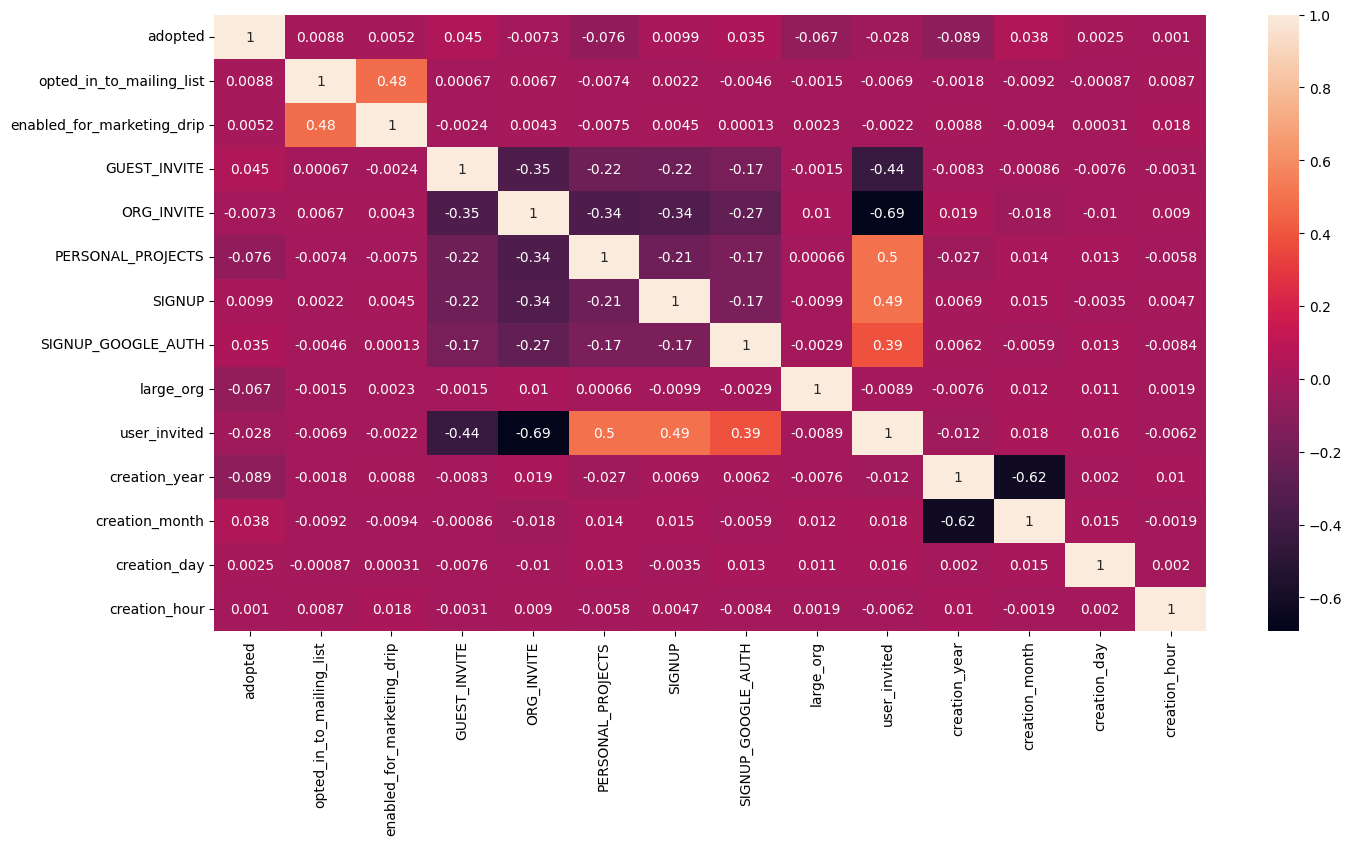

In [59]:
plt.figure(figsize=(16,8))
sns.heatmap(pd.concat([y,X], axis=1).corr('spearman'), annot=True)

In [60]:
X = X.drop(['SIGNUP_GOOGLE_AUTH','creation_month','creation_day','creation_hour'], axis=1)  

In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   GUEST_INVITE                12000 non-null  uint8
 3   ORG_INVITE                  12000 non-null  uint8
 4   PERSONAL_PROJECTS           12000 non-null  uint8
 5   SIGNUP                      12000 non-null  uint8
 6   large_org                   12000 non-null  int32
 7   user_invited                12000 non-null  bool 
 8   creation_year               12000 non-null  int64
dtypes: bool(1), int32(1), int64(3), uint8(4)
memory usage: 738.5 KB


In [62]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   adopted  12000 non-null  bool 
dtypes: bool(1)
memory usage: 363.5 KB


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



RandomForest
gs.best_params_ {'n_estimators': 500}
gs.best_score_ 0.5967767785388922
{'mean_fit_time': array([0.04273658, 0.08257089, 0.16364069, 0.33008351, 0.82170615]), 'std_fit_time': array([0.00143645, 0.00054829, 0.00070776, 0.00265927, 0.00291801]), 'mean_score_time': array([0.00600533, 0.01010876, 0.01881614, 0.03628402, 0.08707485]), 'std_score_time': array([0.00031651, 0.00020013, 0.00024511, 0.00022407, 0.00031666]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.59753165, 0.59841253, 0.59517635, 0.59910616, 0.60080551]), 'split1_test_score': array([0.60346111, 0.59996349, 0.59971619, 0.59930401, 0.6006112 ]), 'split2_test_score': array([0.59486389, 0.59408452, 0.59734755, 0.5946221 , 0.59576064]), '

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


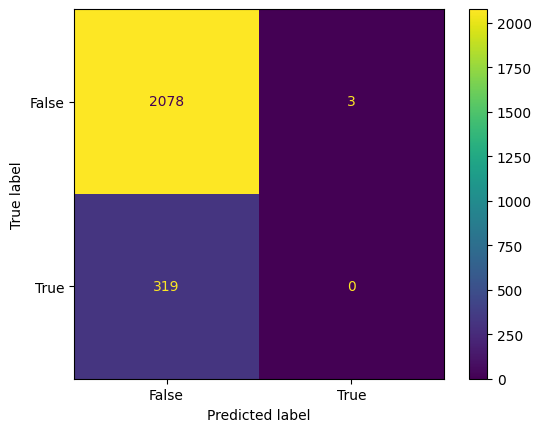

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


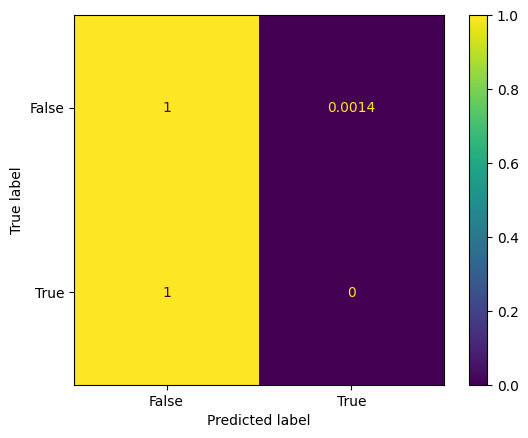

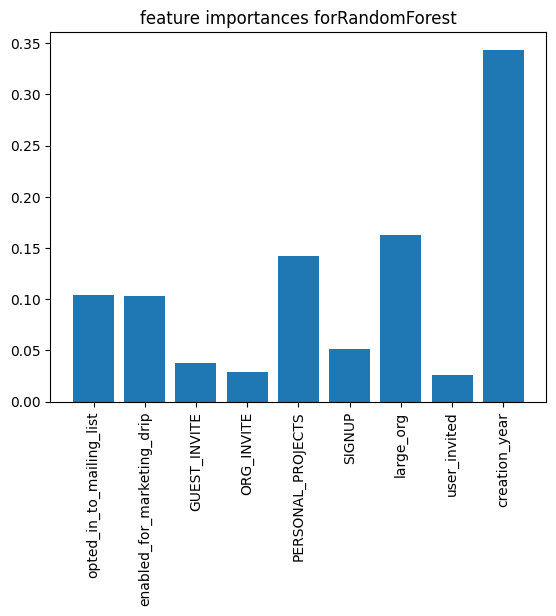



ExtraTrees
gs.best_params_ {'n_estimators': 25}
gs.best_score_ 0.5961706836429808
{'mean_fit_time': array([0.04233627, 0.09117832, 0.16293993, 0.32638016, 0.81440001]), 'std_fit_time': array([0.00051057, 0.0179721 , 0.00208986, 0.00386877, 0.00390963]), 'mean_score_time': array([0.0060051 , 0.01030893, 0.01871614, 0.03753228, 0.08877625]), 'std_score_time': array([2.33601546e-07, 2.45242705e-04, 2.45048068e-04, 2.75902283e-03,
       2.18352291e-03]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.60144262, 0.60144262, 0.60144262, 0.60144262, 0.60144262]), 'split1_test_score': array([0.5989566, 0.5989566, 0.5989566, 0.5989566, 0.5989566]), 'split2_test_score': array([0.59438617, 0.59438617, 0.59438617, 0.594386

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


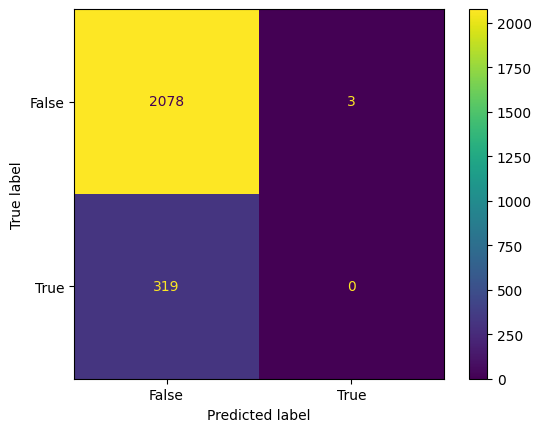

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


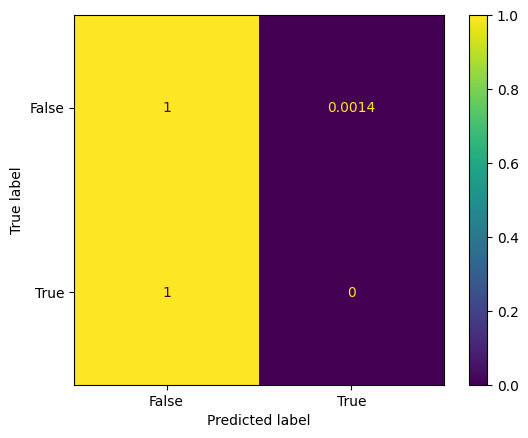

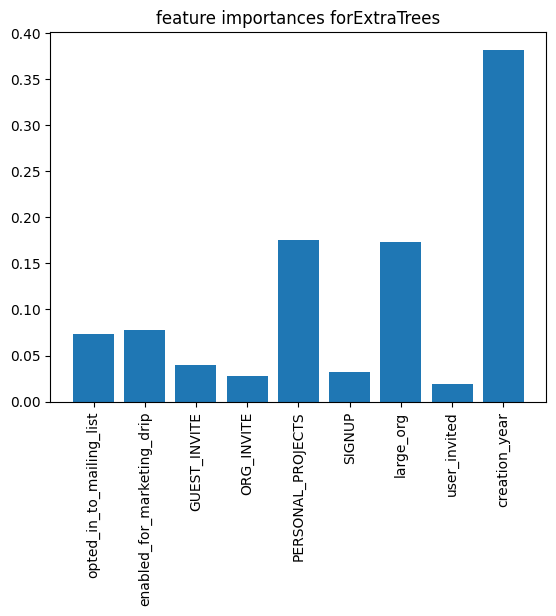



GradientBoosting
gs.best_params_ {'n_estimators': 25}
gs.best_score_ 0.6183597578982315
{'mean_fit_time': array([0.05174437, 0.10048623, 0.19686909, 0.38923435, 0.96983352]), 'std_fit_time': array([0.00040035, 0.000664  , 0.00051024, 0.00259834, 0.00054829]), 'mean_score_time': array([0.0021018 , 0.00300274, 0.00450392, 0.00660563, 0.01371169]), 'std_score_time': array([2.00200159e-04, 3.16506518e-04, 1.78416128e-07, 2.00152475e-04,
       2.45378984e-04]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.61715716, 0.61477124, 0.61466643, 0.61729259, 0.61480539]), 'split1_test_score': array([0.63288936, 0.62575163, 0.62012836, 0.61857622, 0.613941  ]), 'split2_test_score': array([0.61400663, 0.61122483, 0.6091989

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


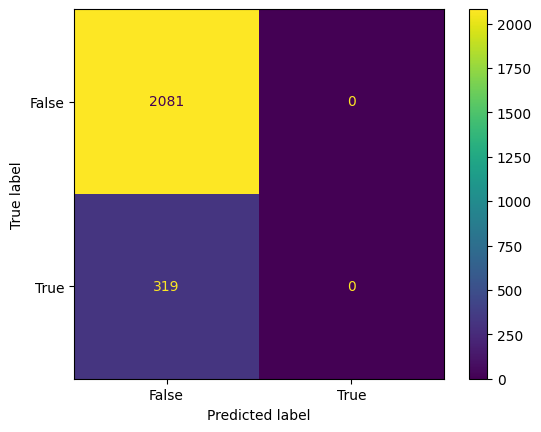

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


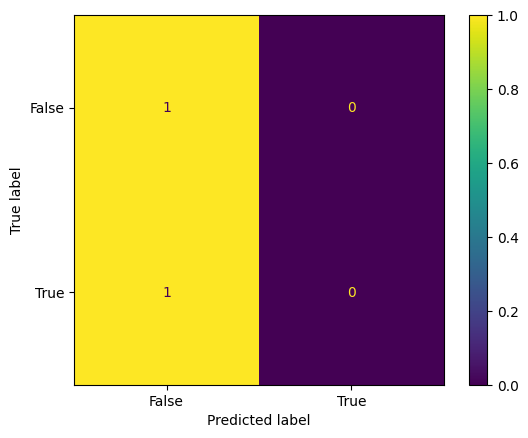

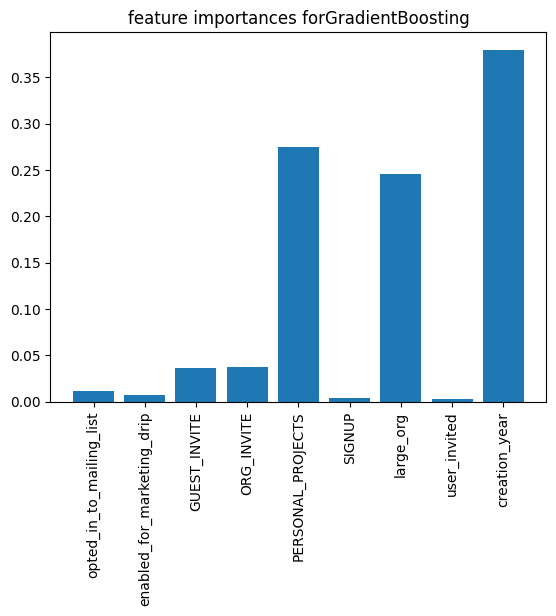

In [64]:
params_rf = {'n_estimators':[25,50,100,200,500]}
params_et = {'n_estimators':[25,50,100,200,500]}
params_gb = {'n_estimators':[25,50,100,200,500]}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train.values.ravel())
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train.values.ravel())
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test.values.ravel()))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel())
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel(), normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()



RandomForest
gs.best_params_ {'n_estimators': 50}
gs.best_score_ 0.5966245864281323
{'mean_fit_time': array([0.04153581, 0.08267274, 0.16243963, 0.32688084, 0.82510905]), 'std_fit_time': array([0.00044761, 0.00111439, 0.0012096 , 0.00313969, 0.00193546]), 'mean_score_time': array([0.00530448, 0.00940652, 0.01781526, 0.03503094, 0.08607392]), 'std_score_time': array([0.00024501, 0.0001992 , 0.00024511, 0.00031666, 0.00044755]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.59993876, 0.60454572, 0.59790143, 0.59880233, 0.60087028]), 'split1_test_score': array([0.59833127, 0.60172761, 0.59924042, 0.60223164, 0.59910381]), 'split2_test_score': array([0.59682171, 0.59570195, 0.59383803, 0.59435918, 0.59548481]), 's

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


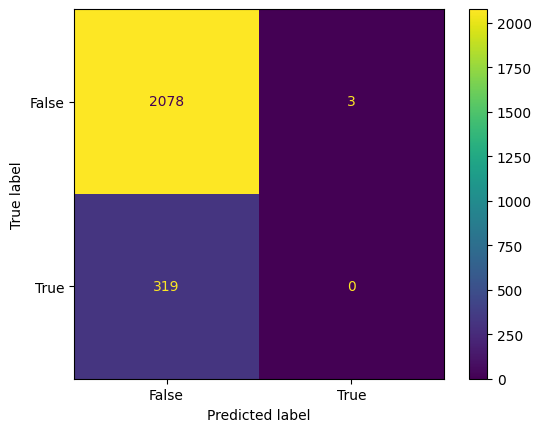

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


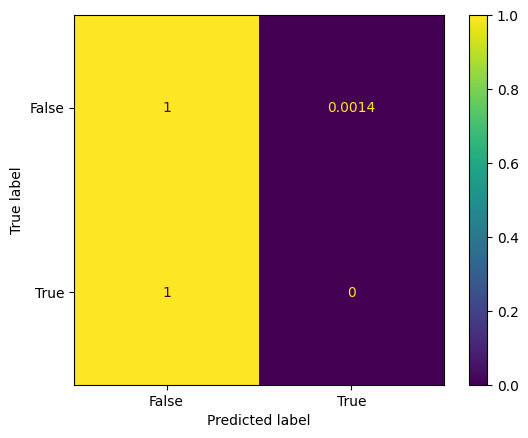

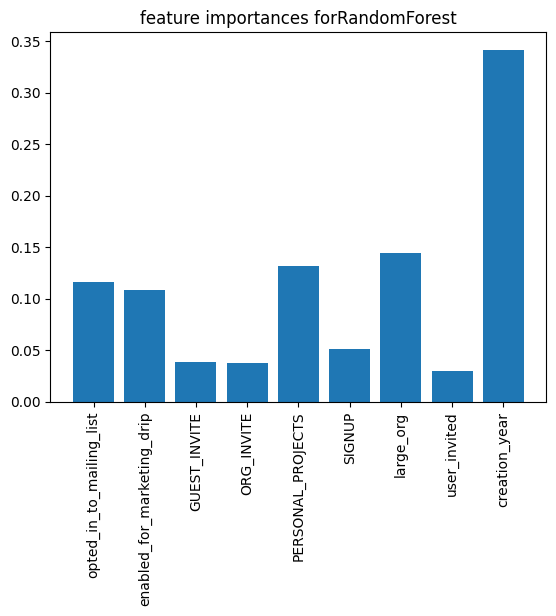



ExtraTrees
gs.best_params_ {'n_estimators': 100}
gs.best_score_ 0.5961786651634136
{'mean_fit_time': array([0.04163547, 0.08197045, 0.16344028, 0.32808185, 0.83301568]), 'std_fit_time': array([0.00020042, 0.00086115, 0.00136498, 0.00225152, 0.02403225]), 'mean_score_time': array([0.00520463, 0.00960817, 0.0181159 , 0.03513017, 0.08617382]), 'std_score_time': array([0.00024532, 0.00020032, 0.0002002 , 0.00020032, 0.00049041]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.60144262, 0.60144262, 0.60144262, 0.60144262, 0.60144262]), 'split1_test_score': array([0.5989566, 0.5989566, 0.5989566, 0.5989566, 0.5989566]), 'split2_test_score': array([0.59438617, 0.59438617, 0.59438617, 0.59438617, 0.59438617]), 'split3_

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


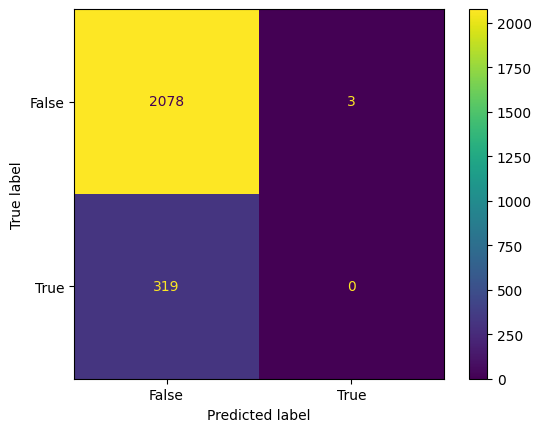

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


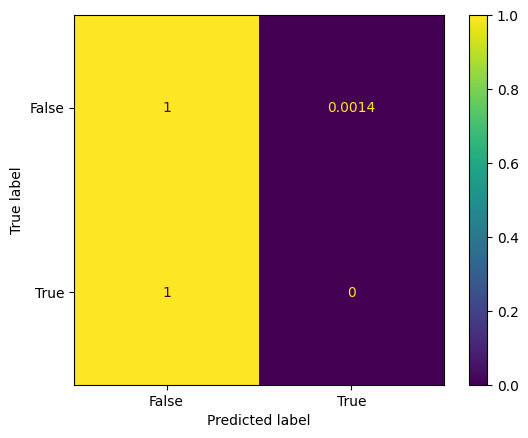

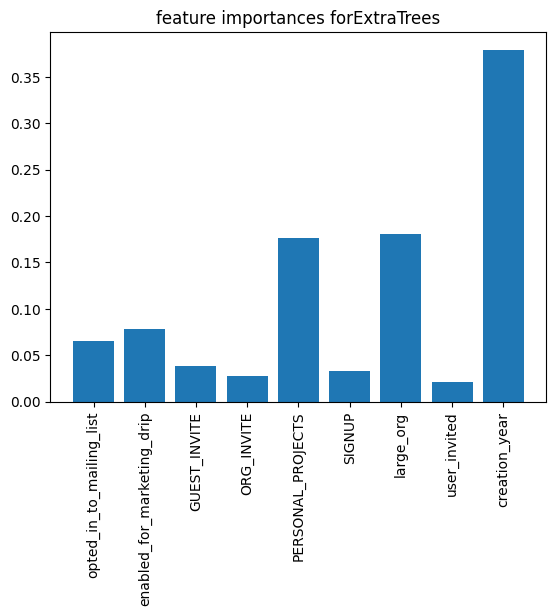



GradientBoosting
gs.best_params_ {'n_estimators': 25}
gs.best_score_ 0.6183597578982315
{'mean_fit_time': array([0.05174446, 0.10148726, 0.20007195, 0.39984322, 0.99485469]), 'std_fit_time': array([0.00024528, 0.00037432, 0.00124188, 0.00212289, 0.00274112]), 'mean_score_time': array([0.00170164, 0.00230203, 0.00360308, 0.00610533, 0.01281123]), 'std_score_time': array([0.00024524, 0.00024516, 0.00020034, 0.00020032, 0.00024493]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.61715716, 0.61477124, 0.61466643, 0.61729259, 0.61480539]), 'split1_test_score': array([0.63288936, 0.62575163, 0.62012836, 0.61857622, 0.613941  ]), 'split2_test_score': array([0.61400663, 0.61122483, 0.60919894, 0.61077177, 0.60733267])

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


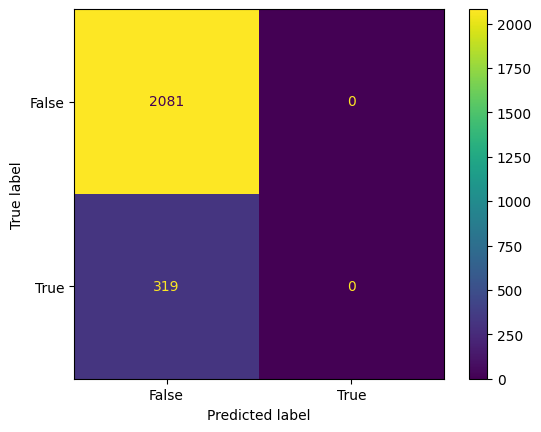

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


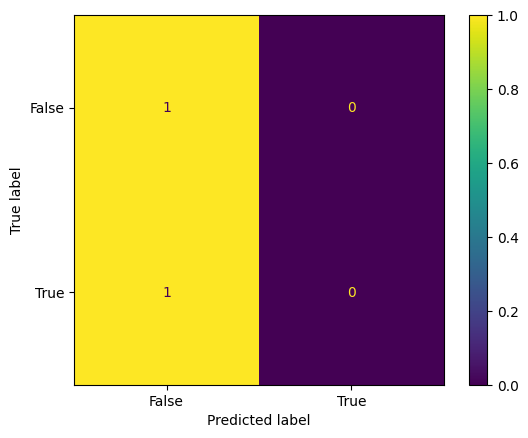

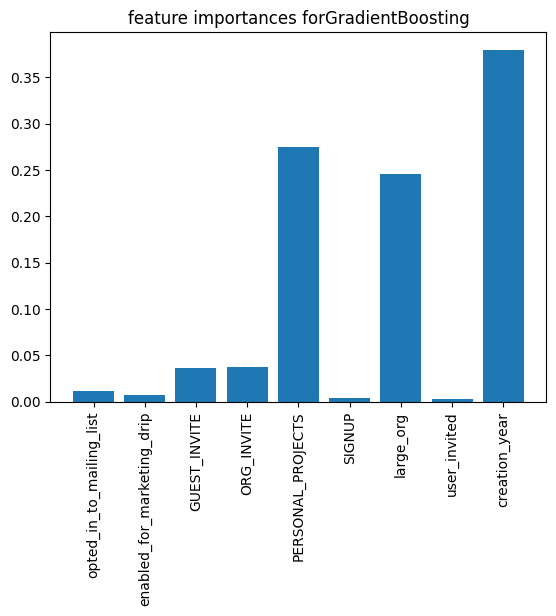

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[25,50,100,200,500]}
params_et = {'n_estimators':[25,50,100,200,500]}
params_gb = {'n_estimators':[25,50,100,200,500]}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train.values.ravel())
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train.values.ravel())
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test.values.ravel()))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel())
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel(), normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()

In [66]:
X_adopted_10000 = X.loc[np.random.choice(y.loc[y.adopted==True].index, size=10000),:]
X_notadopted_10000 = X.loc[np.random.choice(y.loc[y.adopted==False].index, size=10000),:]

X_sampled = pd.concat([X_adopted_10000, X_notadopted_10000], axis=0)
y_sampled = np.append(np.ones(10000), np.zeros(10000))

print(X_sampled.info())
print(y_sampled.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 4145 to 7259
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    20000 non-null  int64
 1   enabled_for_marketing_drip  20000 non-null  int64
 2   GUEST_INVITE                20000 non-null  uint8
 3   ORG_INVITE                  20000 non-null  uint8
 4   PERSONAL_PROJECTS           20000 non-null  uint8
 5   SIGNUP                      20000 non-null  uint8
 6   large_org                   20000 non-null  int32
 7   user_invited                20000 non-null  bool 
 8   creation_year               20000 non-null  int64
dtypes: bool(1), int32(1), int64(3), uint8(4)
memory usage: 800.8 KB
None
(20000,)




RandomForest
gs.best_params_ {'n_estimators': 100}
gs.best_score_ 0.6396547656249999
{'mean_fit_time': array([0.06265364, 0.12000299, 0.23900528, 0.47991247, 1.21013985]), 'std_fit_time': array([0.00193564, 0.0005836 , 0.00150475, 0.00425799, 0.00961738]), 'mean_score_time': array([0.00740643, 0.01341166, 0.02532177, 0.04974265, 0.12380643]), 'std_score_time': array([0.00020013, 0.00020046, 0.00024522, 0.00051029, 0.0008727 ]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.6360918 , 0.63710898, 0.63752285, 0.63750059, 0.63719004]), 'split1_test_score': array([0.64397051, 0.6451959 , 0.6457377 , 0.64593184, 0.64551699]), 'split2_test_score': array([0.63754082, 0.63825488, 0.63902402, 0.63749668, 0.63657949]), '

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


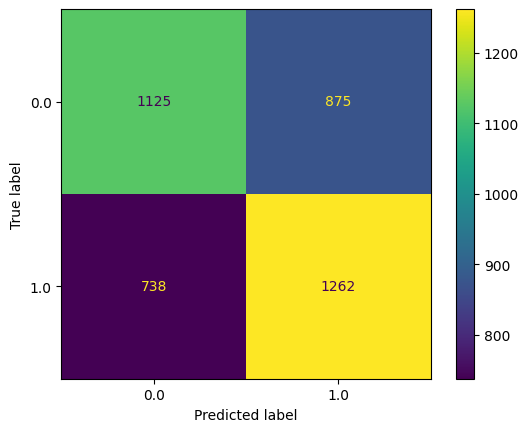

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


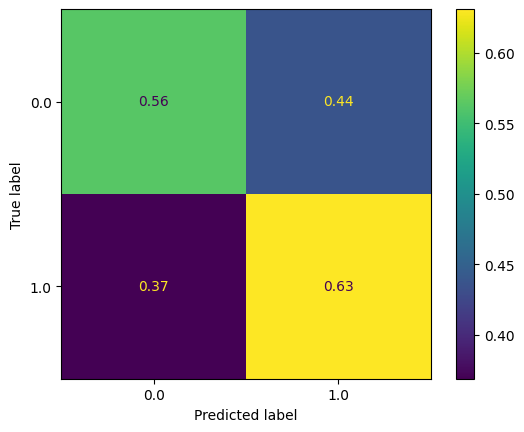

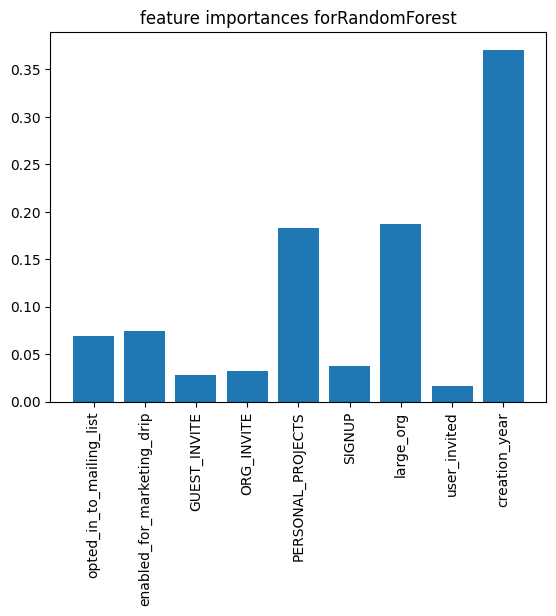



ExtraTrees
gs.best_params_ {'n_estimators': 50}
gs.best_score_ 0.6391010937499999
{'mean_fit_time': array([0.06395493, 0.12610841, 0.25171633, 0.50283203, 1.35236197]), 'std_fit_time': array([0.00037444, 0.00063301, 0.00212295, 0.00097037, 0.16322031]), 'mean_score_time': array([0.00740638, 0.0136117 , 0.02582211, 0.05054359, 0.12911086]), 'std_score_time': array([0.00020022, 0.00020008, 0.00024515, 0.00031643, 0.0102606 ]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.63748848, 0.63748848, 0.63748848, 0.63748848, 0.63748848]), 'split1_test_score': array([0.6454666 , 0.64548496, 0.6454502 , 0.64543105, 0.6454502 ]), 'split2_test_score': array([0.63686914, 0.63686914, 0.63686914, 0.63686914, 0.63686914]), 'spl

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


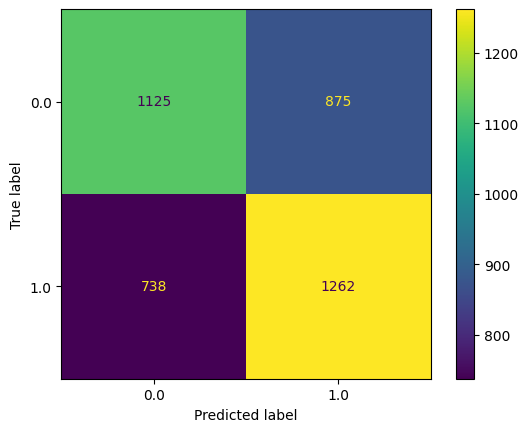

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


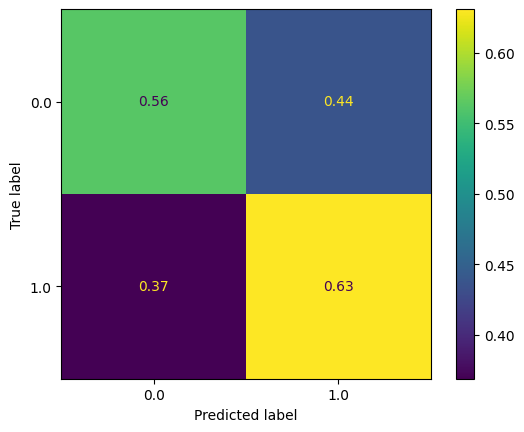

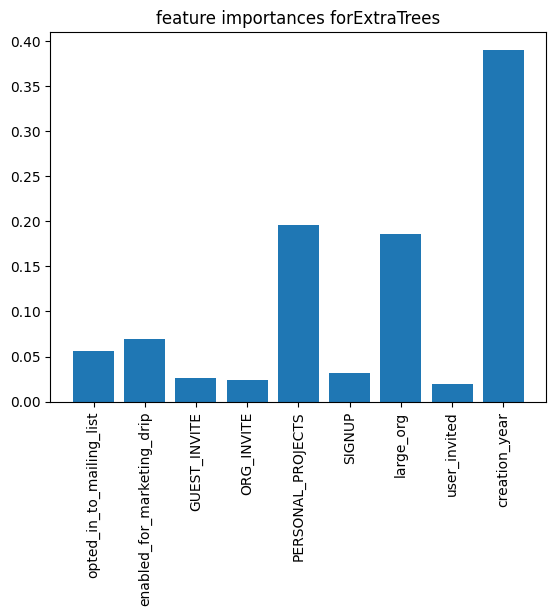



GradientBoosting
gs.best_params_ {'n_estimators': 200}
gs.best_score_ 0.6375815625
{'mean_fit_time': array([0.08207059, 0.16193914, 0.3208756 , 0.63524361, 1.57785573]), 'std_fit_time': array([0.0008376 , 0.00040042, 0.00168656, 0.00256351, 0.00500424]), 'mean_score_time': array([0.00240207, 0.00340304, 0.00540476, 0.00930796, 0.02101817]), 'std_score_time': array([2.00271663e-04, 2.00319375e-04, 2.00414686e-04, 2.45067515e-04,
       3.23406696e-07]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.63360469, 0.63475781, 0.63563164, 0.63431719, 0.633175  ]), 'split1_test_score': array([0.63231445, 0.63251973, 0.63528105, 0.64074355, 0.64082715]), 'split2_test_score': array([0.63705293, 0.637475  , 0.63832266, 0.

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


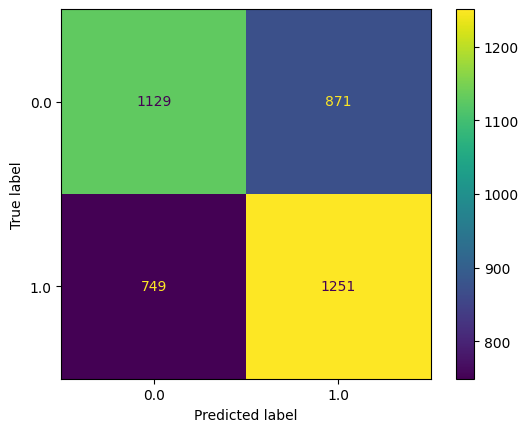

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


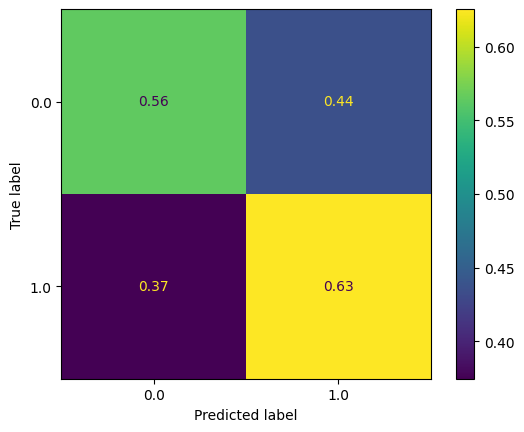

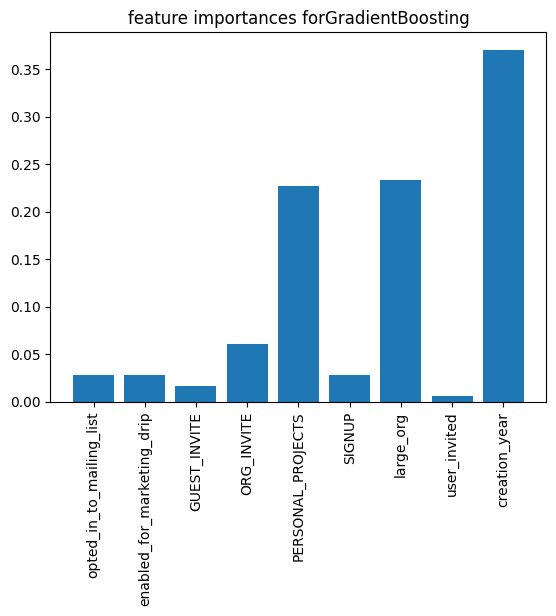

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[25,50,100,200,500]}
params_et = {'n_estimators':[25,50,100,200,500]}
params_gb = {'n_estimators':[25,50,100,200,500]}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train)
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()



RandomForest
gs.best_params_ {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.8, 'n_estimators': 50}
gs.best_score_ 0.63979078125
{'mean_fit_time': array([0.04223633, 0.08297143, 0.12420654, 0.16514182, 0.04273672,
       0.08517318, 0.12580776, 0.16764426, 0.04343729, 0.08557363,
       0.12780976, 0.16984582, 0.04363728, 0.08677449, 0.1295114 ,
       0.1734489 , 0.0445384 , 0.08727479, 0.13121271, 0.17424965,
       0.02762361, 0.05454712, 0.08126969, 0.10829291, 0.04754076,
       0.09388065, 0.14002028, 0.18636012, 0.04804139, 0.09668307,
       0.14472442, 0.19426713, 0.04964266, 0.09878492, 0.14732671,
       0.19586821, 0.05064321, 0.09968567, 0.14892769, 0.19676924,
       0.05094357, 0.10058665, 0.15032902, 0.20047221, 0.02742362,
       0.05404634, 0.08046904, 0.10739241, 0.05424676, 0.10589085,
       0.15933709, 0.21108122, 0.05524759, 0.1091938 , 0.16273985,
       0.21718688, 0.05564752, 0.1108952 , 0.16624279, 0.22018924,
       0.0582499 , 0.11339755, 0.17124696,

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


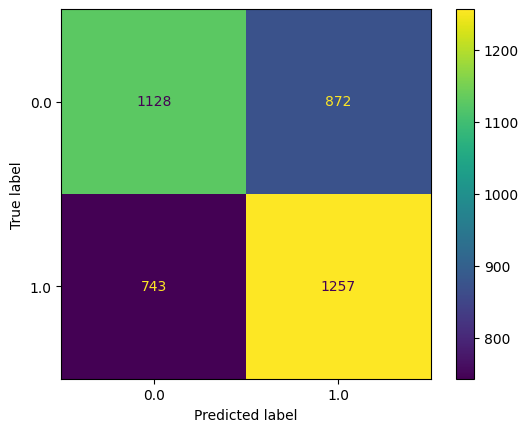

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


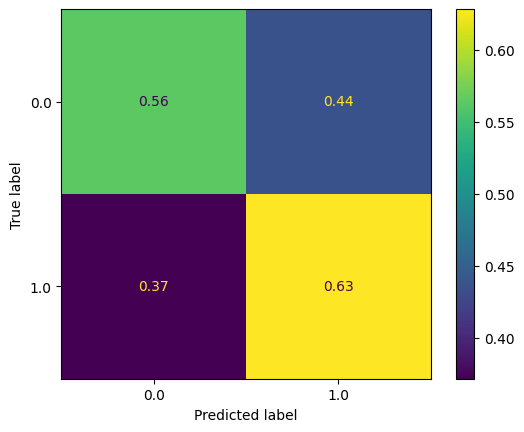

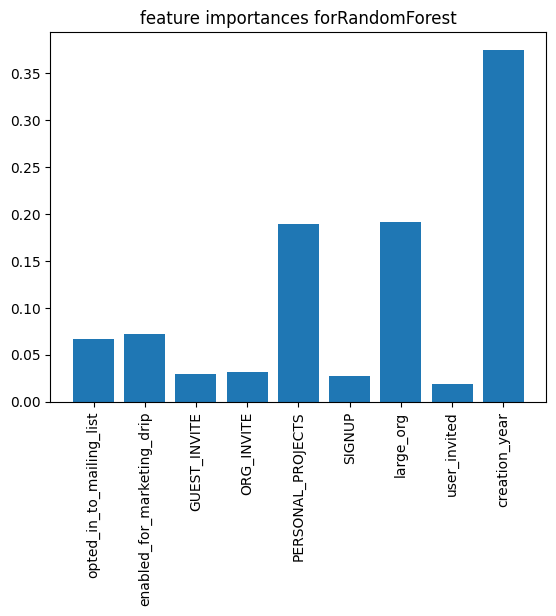



ExtraTrees
gs.best_params_ {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.9, 'n_estimators': 50}
gs.best_score_ 0.6396980468750001
{'mean_fit_time': array([0.04073491, 0.07966843, 0.11960273, 0.15943708, 0.04133587,
       0.08016896, 0.12100377, 0.16163869, 0.04143567, 0.08207059,
       0.1228054 , 0.16374102, 0.04233665, 0.08357162, 0.12440681,
       0.16664329, 0.04303684, 0.08467269, 0.12520742, 0.16714387,
       0.02782397, 0.05544786, 0.08157005, 0.1086936 , 0.04573936,
       0.08937678, 0.13451557, 0.1789537 , 0.04623995, 0.09167881,
       0.13621712, 0.18185625, 0.04734035, 0.09297986, 0.13962002,
       0.18555937, 0.0480412 , 0.0951818 , 0.14202209, 0.18946285,
       0.04894199, 0.09618926, 0.14452424, 0.19146452, 0.02742352,
       0.05374622, 0.080269  , 0.10639162, 0.05124412, 0.10148721,
       0.15112958, 0.20107274, 0.05154409, 0.10258818, 0.15413241,
       0.20597692, 0.0523447 , 0.10438976, 0.15703492, 0.21008081,
       0.05484729, 0.10729227, 0.161038

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


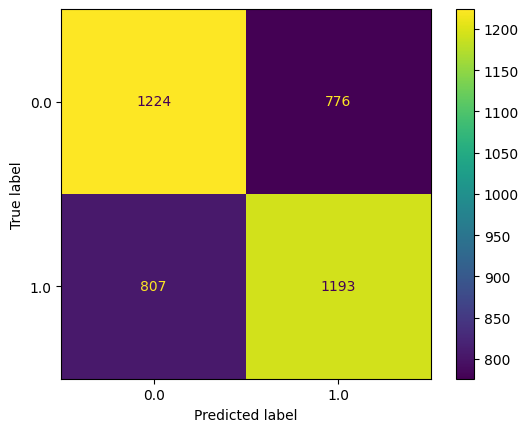

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


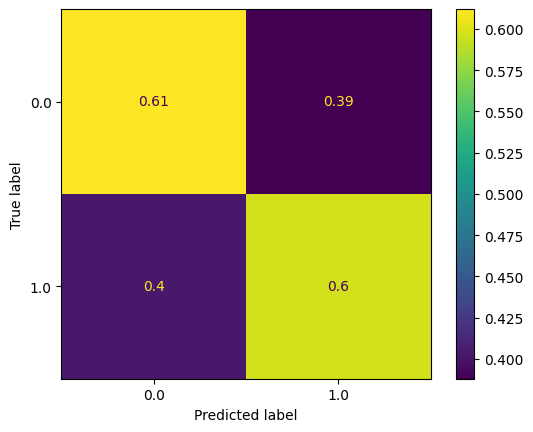

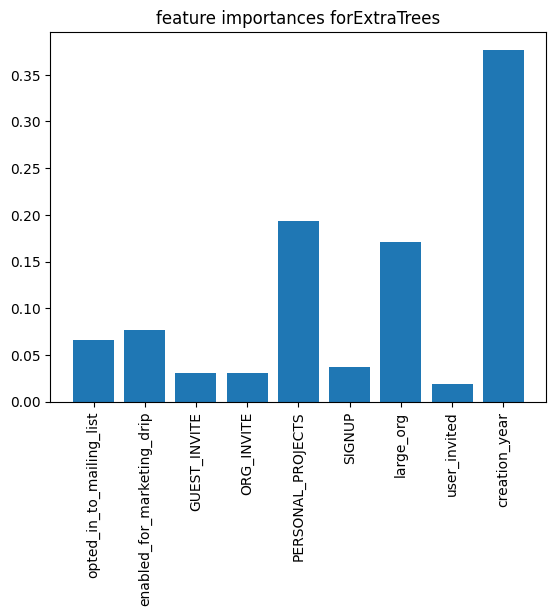

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 



GradientBoosting
gs.best_params_ {'loss': 'deviance', 'n_estimators': 100, 'subsample': 0.75}
gs.best_score_ 0.63759890625
{'mean_fit_time': array([0.0810699 , 0.08126979, 0.08167014, 0.08317161, 0.07976851,
       0.15523329, 0.15903668, 0.16123867, 0.16494184, 0.15823851,
       0.23159914, 0.23730383, 0.24370956, 0.24541092, 0.23700371,
       0.30996642, 0.31517081, 0.32387815, 0.32698083, 0.31477036,
       0.08487287, 0.08527336, 0.08637424, 0.08717508, 0.08377199,
       0.16414104, 0.16734357, 0.1682447 , 0.170046  , 0.16213942,
       0.24380946, 0.24731255, 0.25051532, 0.25261722, 0.24080663,
       0.32147627, 0.33138485, 0.3356885 , 0.34079275, 0.32217679]), 'std_fit_time': array([0.00109628, 0.0005103 , 0.0004904 , 0.00037467, 0.00060039,
       0.00080071, 0.00049033, 0.00066401, 0.00081305, 0.00182864,
       0.00177346, 0.00188316, 0.00230403, 0.00024509, 0.00040032,
       0.00143633, 0.00058381, 0.00282042, 0.00136509, 0.00044766,
       0.00361701, 0.00092798, 0.00

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoosting
accuracy: 0.59175


C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


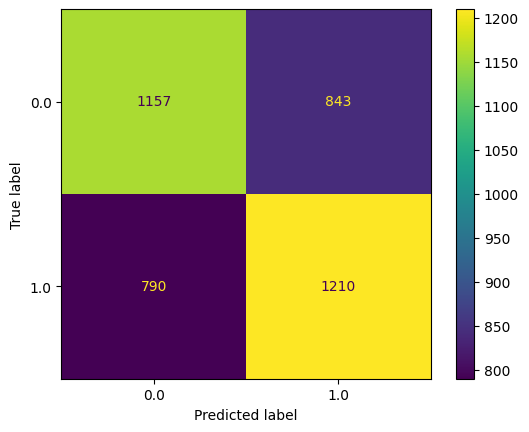

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


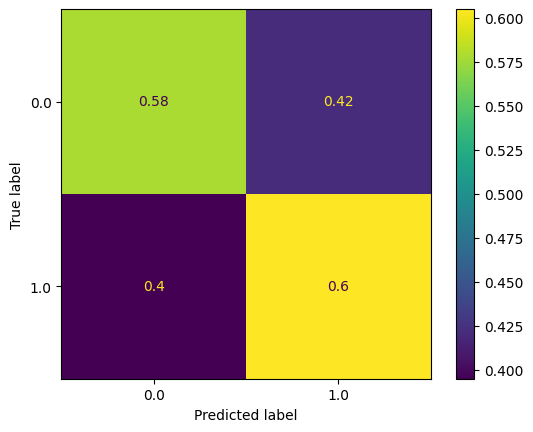

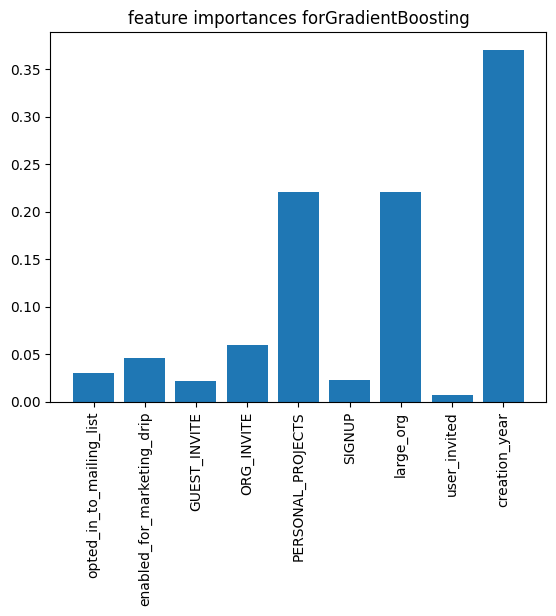

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[25,50,75,100], 'max_samples':[0.7, 0.75, 0.8, 0.85, 0.9, 1], 'bootstrap':[True], 'max_depth':[3,5,8,None]}   # 
params_et = {'n_estimators':[25,50,75,100], 'max_samples':[0.7, 0.75, 0.8, 0.85, 0.9, 1], 'bootstrap':[True], 'max_depth':[3,5,8,None]}  #, 'max_depth':[3,5,8,None]
params_gb = {'n_estimators':[25,50,75,100], 'subsample':[0.7, 0.75, 0.8, 0.85, 1], 'loss':['exponential', 'deviance']}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train)
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()



RandomForest
gs.best_params_ {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.825, 'n_estimators': 50}
gs.best_score_ 0.6395434375
{'mean_fit_time': array([0.11289697, 0.11359744, 0.11489868, 0.11660042, 0.11720042,
       0.05504737, 0.11599965, 0.11710052, 0.11800127, 0.11850185,
       0.11920233, 0.05504732]), 'std_fit_time': array([0.00067882, 0.00031681, 0.00087239, 0.0007754 , 0.00097033,
       0.00031636, 0.00097045, 0.00054842, 0.00049014, 0.00106853,
       0.00058361, 0.00063301]), 'mean_score_time': array([0.01311135, 0.01351171, 0.01341162, 0.01341133, 0.01341171,
       0.00720615, 0.01361156, 0.01361184, 0.0136117 , 0.0135118 ,
       0.01371183, 0.00710602]), 'std_score_time': array([2.00152532e-04, 3.81469727e-07, 2.00200159e-04, 1.99937906e-04,
       2.00247843e-04, 2.45223373e-04, 2.00152418e-04, 2.00128584e-04,
       2.00438634e-04, 2.43140197e-07, 2.45262183e-04, 2.00057051e-04]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, Tr

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


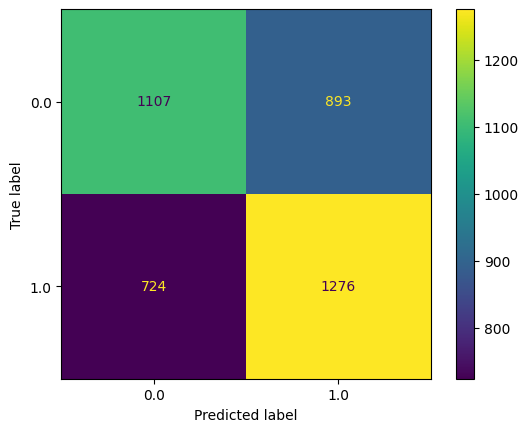

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


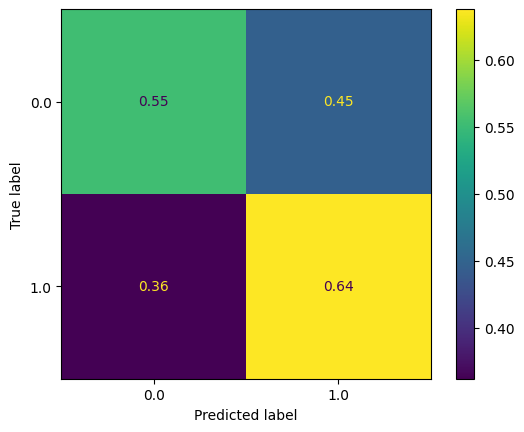

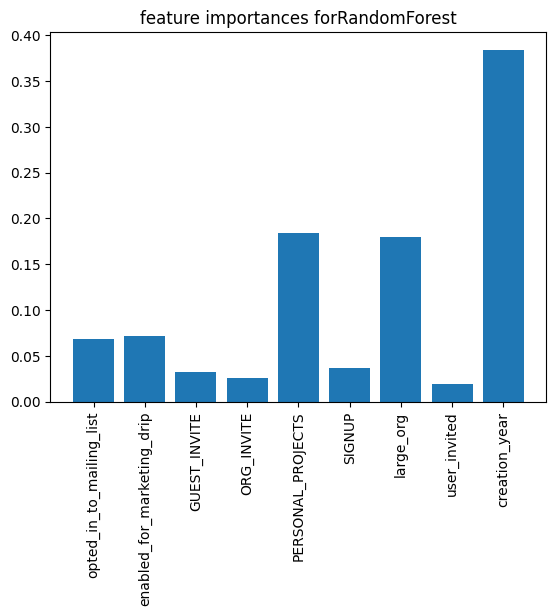



ExtraTrees
gs.best_params_ {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.975, 'n_estimators': 50}
gs.best_score_ 0.63986078125
{'mean_fit_time': array([0.05454679, 0.10839314, 0.05464697, 0.10949397, 0.05724936,
       0.11069508, 0.0557476 , 0.11259656, 0.05804992, 0.11439819,
       0.0590507 , 0.11559672, 0.02952895, 0.05774965, 0.05724936,
       0.10999432, 0.05554771, 0.10969424, 0.05574784, 0.11239672,
       0.05845017, 0.11269703, 0.05644841, 0.11199632, 0.05784955,
       0.11239681, 0.02732348, 0.05364618]), 'std_fit_time': array([0.00077546, 0.00067872, 0.00037436, 0.00243941, 0.00051058,
       0.00239796, 0.00067828, 0.00207539, 0.00054829, 0.00081306,
       0.00044777, 0.00083886, 0.00031658, 0.00074899, 0.00051039,
       0.00193559, 0.00031651, 0.00037448, 0.00051028, 0.00278802,
       0.00019989, 0.00247992, 0.00058367, 0.00058354, 0.00140133,
       0.00051021, 0.0004003 , 0.00058354]), 'mean_score_time': array([0.00740643, 0.01351166, 0.00750632, 0.013511

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


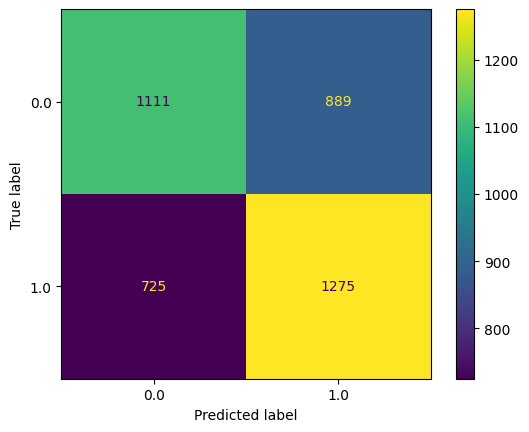

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


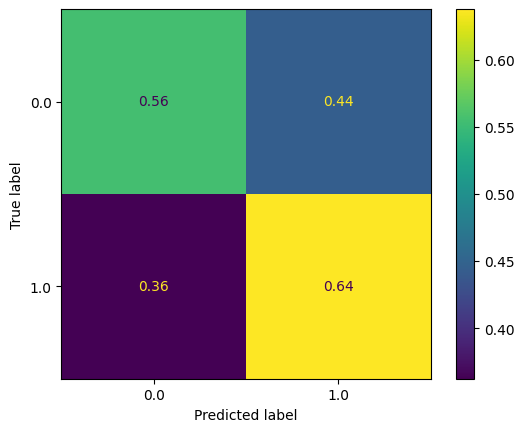

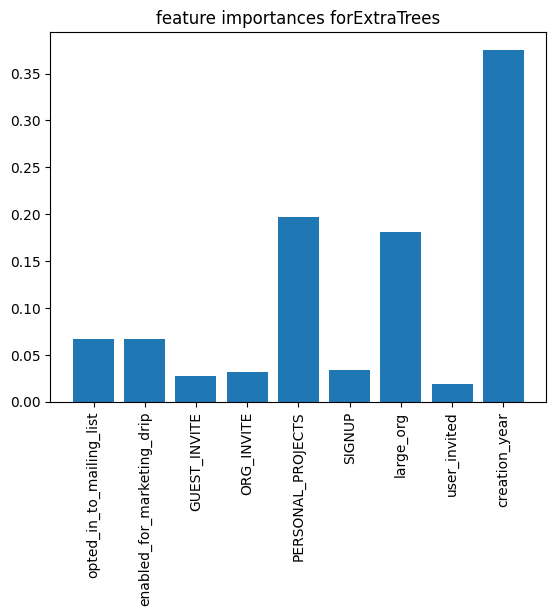

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 



GradientBoosting
gs.best_params_ {'loss': 'deviance', 'n_estimators': 200, 'subsample': 0.75}
gs.best_score_ 0.637616328125
{'mean_fit_time': array([0.29265151, 0.299157  , 0.30676346, 0.31346912, 0.3114675 ,
       0.58580356, 0.60161657, 0.6182313 , 0.62743917, 0.61843133,
       0.8822578 , 0.90187478, 0.92419996, 0.93730521, 0.9303997 ,
       0.31246834, 0.31607132, 0.32207637, 0.32628026, 0.32087564,
       0.61823134, 0.63484302, 0.64225192, 0.65256052, 0.63504581,
       0.92789726, 0.9518178 , 0.96362801, 0.97794027, 0.95742269]), 'std_fit_time': array([0.00086105, 0.0011146 , 0.00094942, 0.00206585, 0.00169256,
       0.00438106, 0.00321854, 0.00442656, 0.00437873, 0.00226909,
       0.00613729, 0.00300932, 0.00562619, 0.00311699, 0.00634894,
       0.00180724, 0.00120912, 0.00180713, 0.00161392, 0.00174523,
       0.00367189, 0.0021112 , 0.00353293, 0.00337912, 0.00192506,
       0.00203653, 0.00478934, 0.00262152, 0.00435579, 0.00770341]), 'mean_score_time': array([0.0055

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoosting
accuracy: 0.59175


C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


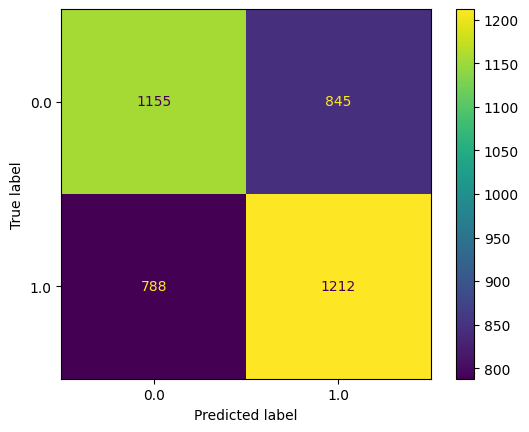

C:\Users\vinhm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


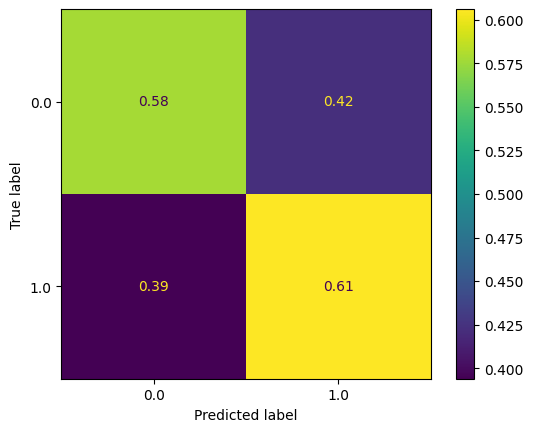

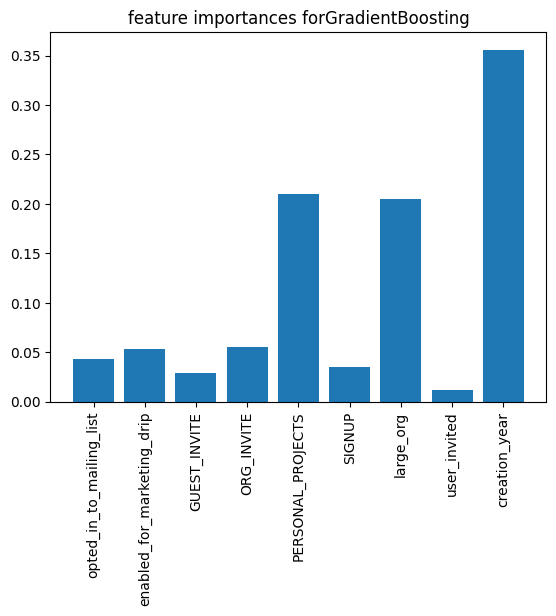

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[50], 'max_samples':[0.8, 0.825, 0.85, 0.875, 0.9, 1], 'bootstrap':[True], 'max_depth':[8,None]}   # 
params_et = {'n_estimators':[25,50], 'max_samples':[0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1], 'bootstrap':[True], 'max_depth':[8,None]}  #, 'max_depth':[3,5,8,None]
params_gb = {'n_estimators':[100, 200, 300], 'subsample':[0.6, 0.65, 0.7, 0.75, 1], 'loss':['exponential', 'deviance']}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train)
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()